In [125]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
import mesa
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime
import random
import heapq

In [126]:
class Door:
    def __init__(self, coord, status, doors):
        self.coord = coord
        self.status = status
        self.doors = doors # Diccionario que mapea las coordenadas de puertas y sus estados

    def openDoor(self):
      if self.status == 'close':
          self.status = 'open'
          self.updateDoorStatus('open')
          print(f"Door at {self.coord} opened.")
      else:
          print("Door is already open or destroyed.")

    def closeDoor(self):
      if self.status == 'open':
          self.status = 'close'
          self.updateDoorStatus('close')
          print(f"Door at {self.coord} closed.")
      else:
          print("Door is already closed or destroyed.")

    # En destroy, las conexiones en el diccionario se retirarían
    def destroyDoor(self):
      if self.status != 'destroyed':
          self.status = 'destroyed'
          self.updateDoorStatus('destroyed')
          print(f"Door at {self.coord} destroyed.")

    def isPassable(self):
      return self.status == 'open' or self.status == 'destroyed'

    def updateDoorStatus(self, new_status):
      self.doors[self.coord][1] = new_status
      for key, value in self.doors.items():
        if self.coord in value[0]:
          self.doors[key][1] = new_status

    # Método para verificar si un agente puede pasar a través de la puerta
    def fireFighterDoorMoves(self, agent, destineCoord):
      x, y = self.coord
      destineX, destineY = destineCoord

      # Verifica si la puerta está en la dirección del movimiento
      if (destineX, destineY) == (x, y) or (x, y) == agent.coord:
        if self.isPassable():
            return True  # La puerta está abierta o destruida, se puede pasar
        else:
            return False  # La puerta está cerrada, no se puede pasar

      # Si la puerta no está en la dirección del movimiento, no interfiere
      return True


In [127]:
class Wall:
    def __init__(self, arrayWall, coord, dmgPoints, model):
        self.arrayWall = arrayWall #array
        self.coord = coord #tuple
        self.dmgPoints = dmgPoints
        self.model = model
        #self.wallDirection = wallDirection

    # fireFighterMoves(self: current wall, agent: Firefighter, destineCoord: (x, y))
    # If return true, hay una pared, no puede pasar
    # If return false, el bombero puede pasar
    '''
    | ! | - Aqui falta poner que la pared de la celda compartiendo pared, tambien se destruye de su lado.
    '''
    def fireFighterWallMoves(self, agent, destineCoord):
        x, y = self.coord
        destineX, destineY = destineCoord

        # if < es Left, if == no se mueve x
        if destineX < x:  # Moving left
            if self.arrayWall[3] != "1":
                return False
        elif destineX > x:  # Moving right
            if self.arrayWall[1] != "1":
                return False
        elif destineY < y:  # Moving up
            if self.arrayWall[0] != "1":
                return False
        elif destineY > y:  # Moving down
            if self.arrayWall[2] != "1":
                return False

        return True  # There's a wall, cannot move
    # takeDamage(self: Wall, damage: int, damageDirection: int)
    # Suma daño a la pared y la quita si es destruida
    # Direction [0]:up [1]:Left [2]:Down [3]:Right
    def takeDamage(self, damage, dmgDirection):
        self.dmgPoints[dmgDirection] += damage
        if self.dmgPoints[dmgDirection] == 2:
            self.dmgPoints[dmgDirection] = 0
            self.arrayWall[dmgDirection] = 0
            print("Wall has been destroyed")
            # Para contador de cuántas paredes han sido destruidas
            return 1
        else:
            print("Wall took 1 of damage")
            # Para contador de cuántas paredes han sido destruidas
            return 0

{(0, 2): [(0, 3), 'close'], (0, 3): [(0, 2), 'close'], (1, 4): [(1, 5), 'close'], (1, 5): [(1, 4), 'close'], (2, 1): [(2, 2), 'close'], (2, 2): [(2, 1), 'close'], (1, 7): [(2, 7), 'close'], (2, 7): [(1, 7), 'close'], (3, 3): [(4, 3), 'close'], (4, 3): [(3, 3), 'close'], (3, 5): [(3, 6), 'close'], (3, 6): [(3, 5), 'close'], (5, 4): [(5, 5), 'close'], (5, 5): [(5, 4), 'close'], (5, 6): [(5, 7), 'close'], (5, 7): [(5, 6), 'close']}


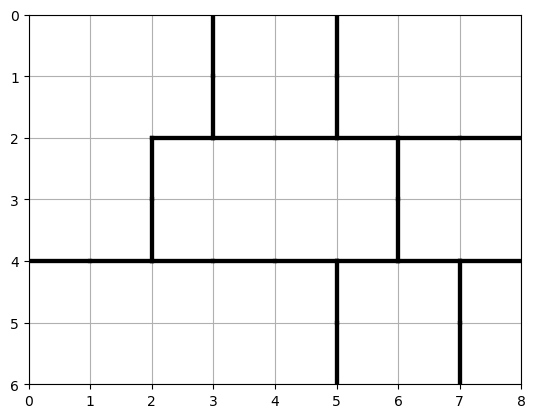

[[None, None, None, None, None, None, None, None], [None, 'F', 'F', 'V', None, None, None, None], [None, 'F', 'F', 'F', 'F', None, None, None], [None, None, None, 'F', None, None, None, None], ['FA', None, None, None, None, 'F', 'F', 'V'], [None, None, None, None, None, 'F', None, None]]


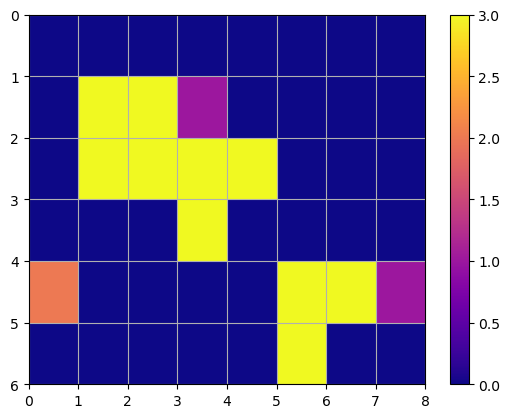

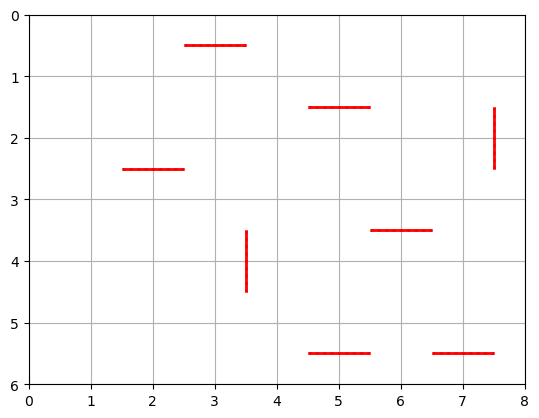

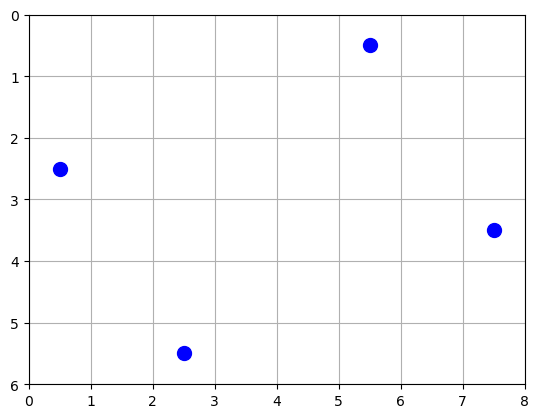

In [115]:
wallData = []
FirePOI = []
doors = {}
entryPoints = []

with open('wall.txt', 'r') as file:
    sections = file.read().strip().split('\n\n')

    for line in sections[0].strip().split('\n'):
        wallData.append(line.split())

    for line in sections[1].strip().split('\n'):
        FirePOI.append([None if val == 'None' else val for val in line.split()])

# Modificar DOORS AHHH
    # Procesar el contenido línea por línea
    for line in sections[2].strip().split('\n'):
        key, value = line.split(': ')
        key = eval(key)  # Convertir la cadena a una tupla
        value = eval(value)  # Convertir la cadena a una lista con tupla y cadena
        doors[key] = value

    # Mostrar el diccionario resultante
    print(doors)


    for line in sections[3].strip().split('\n'):
        # Split the line into components
        parts = line.split()
        # Clean the strings and convert to integers
        x = int(parts[0].strip('(),'))
        y = int(parts[1].strip('(),'))
        # Append as a tuple
        entryPoints.append((x, y))


dmgPoints = [['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
             ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
             ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
             ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
             ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
             ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000']]

# Las puertas consisten en conexiones entre indices de los diccionarios acorde al tablero
# Las posiciones inician en 0 para seguir el estándar de la matriz WallData

# Los puntos de entrada consisten en celdas junto a un punto de entrada en el tablero
# Las posiciones inician en 0 para seguir el estándar de la matriz WallData

wall_fires = []

for i in range(len(wallData)):
  for j in range(len(wallData[i])):
    if (FirePOI[i][j] == "F" or FirePOI[i][j] == "S") and '1' in wallData[i][j]:
      wall_fires.append((i, j))

"""
for i in range(wallData):
    for j in range(wallData[0]):
        new Wall(wallData[i][j], (i - 1, j - 1), 0)
"""
rows = len(wallData)
cols = len(wallData[0])

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Configurar los límites del grid
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.grid()

# Dibujar las paredes según los valores en wallData
#matplotlib.rcParams['linewidth'] = 2
for i in range(0, rows):
    for j in range(0, cols):
        cell = wallData[i][j]
        if cell[0] == "1":  # Pared al norte
            ax.plot([j, j + 1], [i, i], 'k-', linewidth=3)
        if cell[1] == "1":  # Pared al este
            ax.plot([j + 1, j + 1], [i, i + 1], 'k-', linewidth=3)
        if cell[2] == "1":  # Pared al sur
            ax.plot([j, j + 1], [i + 1, i + 1], 'k-', linewidth=3)
        if cell[3] == "1":  # Pared al oeste
            ax.plot([j, j], [i, i + 1], 'k-', linewidth=3)
    
# Ajustar la visualización
ax.set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()


# Graficar FirePOI
rowsFirePOI = len(FirePOI)
colsFirePOI = len(FirePOI[0])

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Configurar los límites del grid
ax.set_xlim(0, colsFirePOI)
ax.set_ylim(0, rowsFirePOI)
ax.grid()
print(FirePOI)
FirePOIMatrix = np.zeros((rowsFirePOI, colsFirePOI))
# Dibujar el fuego y POIs 
for i in range(rowsFirePOI):
    for j in range(colsFirePOI):
      cell = FirePOI[i][j]
      if cell == "F": # Celda con fuego
        FirePOIMatrix[i, j] = 3
      elif cell == "FA": # Celda con falsa alarma
        FirePOIMatrix[i, j] = 2
      elif cell == "V": # Celda con víctima
        FirePOIMatrix[i, j] = 1

plt.pcolormesh(FirePOIMatrix, cmap='plasma')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()


# Graficar las puertas
for key, value in doors.items():
    y1, x1 = key
    (y2, x2), status = value

    
    # Ajustar las posiciones para graficar las puertas en el centro de las celdas
    x1_center = x1 + 0.5
    y1_center = y1 + 0.5
    x2_center = x2 + 0.5
    y2_center = y2 + 0.5

    # Determinar el color y estilo de la línea según el estado de la puerta
    if status == 'close':
        color = 'red'  # Puertas cerradas en rojo
        linestyle = '--'  # Línea discontinua
    else:
        color = 'green'  # Puertas abiertas en verde (u otro estado)
        linestyle = '-'  # Línea continua

    # Dibujar puertas como lineas verdes entre celdas conectadas
    plt.plot([x1_center, x2_center], [y1_center, y2_center], color=color, linestyle=linestyle, linewidth=2)

plt.xlim(0, cols)
plt.ylim(0, rows)
ax.set_aspect('equal')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()


# Graficar los puntos de entrada
#CAMBIAR A ARREGLO
for i in range(0, len(entryPoints)):
      x_center = entryPoints[i][1] + 0.5
      y_center = entryPoints[i][0] + 0.5
      plt.plot(x_center, y_center, 'bo', markersize=10)  # Punto azul para entrada

plt.xlim(0, cols)
plt.ylim(0, rows)
ax.set_aspect('equal')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

# Grafica con los elementos unidos

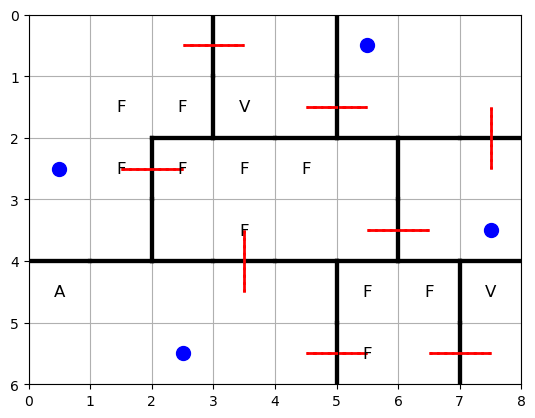

In [116]:
# Crear la figura y los ejes
fig, ax = plt.subplots()

# Configurar los límites del grid
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.grid()

# Dibujar las paredes y puertas en el mismo bucle
for i in range(0, rows):
    for j in range(0, cols):
        cell = wallData[i][j]

        # Dibujar las paredes
        if cell[0] == "1":  # Pared al norte
            ax.plot([j, j + 1], [i, i], 'k-', linewidth=3)
        if cell[1] == "1":  # Pared al este
            ax.plot([j + 1, j + 1], [i, i + 1], 'k-', linewidth=3)
        if cell[2] == "1":  # Pared al sur
            ax.plot([j, j + 1], [i + 1, i + 1], 'k-', linewidth=3)
        if cell[3] == "1":  # Pared al oeste
            ax.plot([j, j], [i, i + 1], 'k-', linewidth=3)

        # Dibujar puertas si la celda actual tiene una
        # Al rows y colums, lo que significa que en cartesianas, x e y se invierten
        if (i, j) in doors:
            y1, x1 = i, j
            (y2, x2), status = doors[(i, j)]

            # Ajustar las posiciones para graficar las puertas en el centro de las celdas
            x1_center = x1 + 0.5
            y1_center = y1 + 0.5
            x2_center = x2 + 0.5
            y2_center = y2 + 0.5

             # Determinar el color y estilo de la línea según el estado de la puerta
            if status == 'close':
                color = 'red'  # Puertas cerradas en rojo
                linestyle = '--'  # Línea discontinua
            else:
                color = 'green'  # Puertas abiertas en verde (u otro estado)
                linestyle = '-'  # Línea continua

            # Dibujar puertas como líneas entre celdas conectadas
            plt.plot([x1_center, x2_center], [y1_center, y2_center], color=color, linestyle=linestyle, linewidth=2)

        

        # Dibujar FirePOI en la celda
        if FirePOI[i][j] is not None:
            x_center = j + 0.5
            y_center = i + 0.5

            if FirePOI[i][j] == "F":
                plt.text(x_center, y_center, "F", ha='center', va='center', fontsize=12)
            elif FirePOI[i][j] == "V":
                plt.text(x_center, y_center, "V", ha='center', va='center', fontsize=12)
            elif FirePOI[i][j] == "FA":
                plt.text(x_center, y_center, "A", ha='center', va='center', fontsize=12)

# Graficar los puntos de entrada
# Se lee utilizando rows y colums, lo que significa que en cartesianas, x e y se invierten
for i in range(0, len(entryPoints)):
      x_center = entryPoints[i][1] + 0.5
      y_center = entryPoints[i][0] + 0.5
      plt.plot(x_center, y_center, 'bo', markersize=10)  # Punto azul para entrada

# Ajustar la visualización
ax.set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

# Lista de Pendientes
- Recoger victima despues de hacer una acción donde la baja.
- Checar array de las Doors para axeWall()
- interactDoor()
- Poner dirección con directionAgent para axeWall()
- def takeVictim(self) ✅

In [124]:
class FireFighterAgent(Agent):
    def __init__(self, id, Model, actionPoints, victims):
      super().__init__(id, Model)
      self.actionPoints = actionPoints
      self.victims = victims
      self.knockOut = False
      self.memoryVictim = 0 #Recordar si bajo a una victima, antes de moverse
      self.actionFirefighter = 'Move' # Accion actual del agente

    def setAction(self, actionFirefighter):
      # Metodo para cambiar la accion de agente
      self.actionFirefighter = actionFirefighter

    def step(self):
        if self.actionPoints <= 0:
            return  # No action if there are no action points left
        
        if self.actionFirefighter == 'Move':
          # Llamar al metodo del movimiento
          success = self.move_randomly()
          if success:
            print(f"Agente {self.unique_id} se movio ")
          else:
            print(f"Agente {self.unique_id} no su pudo mover")
    
    def dijkstra(self, start, targets):
        # Initialize distances and previous nodes. They are set to infinity couse they are unknown
        distances = {cell: float('inf') for cell in self.model.grid.coord_iter()}
        distances[start] = 0
        priority_queue = [(0, start)]  # (distance, cell)
        visited = set()

        while priority_queue:
            current_distance, current_cell = heapq.heappop(priority_queue)

            if current_cell in visited:
                continue

            visited.add(current_cell)

            if current_cell in targets:
                # Return the path to the target found
                return current_cell, distances[current_cell]

            neighbors = self.model.grid.get_neighborhood(current_cell, moore=False, include_center=False)

            for neighbor in neighbors:
                if neighbor not in visited and self.model.grid.is_cell_empty(neighbor):
                    distance = current_distance + 1  # Assuming all edges have the same weight
                    if distance < distances[neighbor]:
                        distances[neighbor] = distance
                        heapq.heappush(priority_queue, (distance, neighbor))

        return None, float('inf')  # No path found

    def find_and_move(self, targets):
        target, distance = self.dijkstra(self.pos, targets)
        if target:
            self.move(self.model.FirePOI, self.model.wallData, target)
            print(f"Agente {self.unique_id} se movió hacia {target}")
        else:
            print(f"Agente {self.unique_id} no encontró un camino a las víctimas o FA")

    def knockOut(self, exitCoord, vicitmsLostCount):
        self.knockOut = True
        if self.victim == 1:
            self.victim == 0
            victimsLostCount += 1
        self.coord = None
        return victimsLostCount

    def move_randomly(self):
      #Selecciona un vecino aleatorio y trata de moverse hacia allí.
      neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
      print(f"Vecinos disponibles para el agente {self.unique_id}: {neighbors}")
      possible_moves = [neighbor for neighbor in neighbors if self.model.grid.is_cell_empty(neighbor)]

      if possible_moves:
          destineCoord = random.choice(possible_moves)
          print(f"Agente {self.unique_id} intenta moverse a {destineCoord}")
          success = self.move(self.model.FirePOI, self.model.wallData, destineCoord)
          return success
      return False

    def move(self, FirePOI, wallData, destineCoord):
      # Intenta mover el agente a la coordenada destino.
        if not self.model.grid.is_cell_empty(destineCoord):
            return False
        if 0 <= destineCoord[0] < len(wallData[0]) and 0 <= destineCoord[1] < len(wallData):          # Find the Wall object corresponding to the agent's current position
            current_wall = next(
                (wall for wall in self.model.walls if wall.coord == self.pos), None
            )
            if current_wall:
                if not current_wall.fireFighterWallMoves(self, destineCoord):
                    self.model.grid.move_agent(self, destineCoord)
                    print(f"Agent {self.unique_id} moved to {destineCoord}")
                    return True
                else:
                    print(
                        f"Agent {self.unique_id} could not move to {destineCoord}. Blocked by a wall"
                    )
                    return False
            else:
                print(f"No wall found at {self.pos}")
                return False
        else:
            print(f"Agent {self.unique_id} is at an invalid position: {self.pos}")
            return False
      
    
    def axeWall(self, FirePOI, Wall, axeDirection):
        if self.victim == 1:
            self.victim == 0
            self.firePOI[self.pos] = 'V'
            # | ! | - No puede estar cargando con la víctima cuando destruye la pared 
        Wall.takeDamage(1, axeDirection)
        
    def leaveVicitm(self, FirePOI):
        if FirePOI[self.pos] == None:
            self.victim = 0
            self.memoryVictim = 1
        else:
            self.actionPoints -= 1
            print('No se puede poner víctima')
            return False
            

    def takeVictim(self):
        if self.FirePOI[self.pos] == 'V':
            if self.victim == 0:
                self.victim = 1
                print('Recoger víctima')
            else:
                self.actionPoints -= 1
                print('Ya cargas con una víctima')
                return False
        else:
            self.actionPoints -= 1
            print('Falsa Alarma | No hay una victima aquí')
            return False
            
   # | ! | - Door como se va a poner??????         
    def interactDoor(self, Door, actionFirefighter):
        if self.victim == 0:
            if actionFirefighter == 'openDoor':
                if Door.isPassable() == False:
                    self.actionPoints -= 1
                    Door.openDoor()
                else:
                    self.actionPoints += 1
                    print('Door already open or destroyed')
            if actionFirefighter == 'closeDoor':
                if Door.isPassable() == True: #Open
                    self.actinoPoints -= 1
                    Door.closeDoor()
                else:
                    self.actionPoints += 1
                    print('Door already closed')
        else:
            self.leaveVcitim(FirePOI)

    def extinguishFire(self, FirePOI, firePos):
        if FirePOI[firePos] == 'F':
            self.actionPoints -= 1
            FirePOI[firePos] = 'S'
        elif FirePOI[firePos] == 'S':
            self.actionPoints -= 1
            FirePOI[firePos] = None
        else:
            self.actionPoints += 1
            return    
    

In [118]:
def get_grid(model):
    grid = np.zeros((model.grid.height, model.grid.width))
    for x in range(model.width):
      for y in range(model.height):
          if model.FirePOI[y][x] == "F":
              grid[y, x] = 1
          elif model.FirePOI[y][x] == "FA":
              grid[y, x] = 2
          elif model.FirePOI[y][x] == "V":
              grid[y, x] = 3

    for agent in model.schedule.agents:
      x, y = agent.pos
      grid[y, x] = 4

    return grid

In [119]:
class FireModel(Model):
  def __init__(self, wallData, doors, entryPoints, FirePOI, firefighters):
    super().__init__()
    self.firefighters = firefighters
    self.width = len(wallData[0])
    self.height = len(wallData)
    self.wallData = wallData
    self.doors = doors
    self.entryPoints = entryPoints
    self.FirePOI = FirePOI
    self.victimsCount = 0
    self.falseAlarmCount = 0
    self.victimsLostCount = 0
    self.walls = [] # Lista para mantener las paredes
    self.grid = SingleGrid(self.width, self.height, torus=False)
    self.schedule = RandomActivation(self)

    self.initializeGrid()

    # Recolectores de datos
    self.datacollector = DataCollector({"Grid": get_grid})

    self.placeAgents()

  def placeAgents(self):
    # Añadir bomberos en posiciones aleatorias
    for i in range(self.firefighters):
      agent = FireFighterAgent(i, self, 10, 0)
      self.grid.move_to_empty(agent)
      self.schedule.add(agent)
      print(f"Agente {i} colocado en {agent.pos}")

  def initializeGrid(self):
    for y in range(self.height):
      for x in range(self.width):
        cell = self.wallData[y][x]
        wall = Wall(cell, (x, y), [0, 0, 0, 0], self)
        self.walls.append(wall)

    for key, value in self.doors.items():
      door = Door(key, value, self)
      self.doors[key] = (value[0], door)

  def dice(self):
    x = random.randint(1, 8)
    y = random.randint(1, 6)
    return x, y

  def visualize_grid(self):
    grid_data = self.datacollector.get_model_vars_dataframe()["Grid"].values[-1]

    # Crear la figura y los ejes
    fig, ax = plt.subplots()

    # Configurar los límites del grid
    ax.set_xlim(0, self.width)
    ax.set_ylim(0, self.height)
    ax.grid()

    # Dibujar las paredes, puertas y FirePOI en el mismo bucle
    for i in range(self.height):
        for j in range(self.width):
            cell = self.wallData[i][j]

            # Dibujar las paredes
            if cell[0] == "1":  # Pared al norte
                ax.plot([j, j + 1], [i, i], 'k-', linewidth=3)
            if cell[1] == "1":  # Pared al este
                ax.plot([j + 1, j + 1], [i, i + 1], 'k-', linewidth=3)
            if cell[2] == "1":  # Pared al sur
                ax.plot([j, j + 1], [i + 1, i + 1], 'k-', linewidth=3)
            if cell[3] == "1":  # Pared al oeste
                ax.plot([j, j], [i, i + 1], 'k-', linewidth=3)

            # Dibujar puertas si la celda actual tiene una
            if ((i, j), status) in self.doors:
                y1, x1 = i, j
                y2, x2 = self.doors[(i, j)]

                # Ajustar las posiciones para graficar las puertas en el centro de las celdas
                x1_center = x1 + 0.5
                y1_center = y1 + 0.5
                x2_center = x2 + 0.5
                y2_center = y2 + 0.5


                # Determinar el color y estilo de la línea según el estado de la puerta
                if status == 'close':
                    color = 'red'  # Puertas cerradas en rojo
                    linestyle = '--'  # Línea discontinua
                else:
                    color = 'green'  # Puertas abiertas en verde (u otro estado)
                    linestyle = '-'  # Línea continua
                
                # Dibujar puertas como líneas verdes entre celdas conectadas
                ax.plot([x1_center, x2_center], [y1_center, y2_center], color=color, linestyle=linestyle, linewidth=2)

            # Dibujar FirePOI en la celda
            if self.FirePOI[i][j] is not None:
                x_center = j + 0.5
                y_center = i + 0.5

                if self.FirePOI[i][j] == "F":
                    ax.text(x_center, y_center, "F", ha='center', va='center', fontsize=12)
                elif self.FirePOI[i][j] == "V":
                    ax.text(x_center, y_center, "V", ha='center', va='center', fontsize=12)
                elif self.FirePOI[i][j] == "FA":
                    ax.text(x_center, y_center, "A", ha='center', va='center', fontsize=12)

    # Dibujar los agentes (firefighters)
    for agent in self.schedule.agents:
        x_center = agent.pos[1] + 0.5  # Convertir coordenadas del grid a coordenadas gráficas
        y_center = agent.pos[0] + 0.5
        ax.plot(x_center, y_center, 'ro', markersize=10)  # Dibujar como un punto rojo

    # Graficar los puntos de entrada
    for (y, x) in self.entryPoints:
        x_center = x + 0.5
        y_center = y + 0.5
        ax.plot(x_center, y_center, 'bo', markersize=10)  # Punto azul para entrada

    # Ajustar la visualización
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()
    plt.show()


  def step(self):
    self.datacollector.collect(self)
    self.schedule.step()


Agente 0 colocado en (2, 3)
Vecinos disponibles para el agente 0: ((1, 3), (2, 2), (2, 4), (3, 3))
Agente 0 intenta moverse a (1, 3)
Agent 0 could not move to (1, 3). Blocked by a wall
Agente 0 no su pudo mover
Vecinos disponibles para el agente 0: ((1, 3), (2, 2), (2, 4), (3, 3))
Agente 0 intenta moverse a (2, 2)
Agent 0 moved to (2, 2)
Agente 0 se movio 
Vecinos disponibles para el agente 0: ((1, 2), (2, 1), (2, 3), (3, 2))
Agente 0 intenta moverse a (1, 2)
Agent 0 could not move to (1, 2). Blocked by a wall
Agente 0 no su pudo mover
Vecinos disponibles para el agente 0: ((1, 2), (2, 1), (2, 3), (3, 2))
Agente 0 intenta moverse a (2, 1)
Agent 0 could not move to (2, 1). Blocked by a wall
Agente 0 no su pudo mover
Vecinos disponibles para el agente 0: ((1, 2), (2, 1), (2, 3), (3, 2))
Agente 0 intenta moverse a (1, 2)
Agent 0 could not move to (1, 2). Blocked by a wall
Agente 0 no su pudo mover
Vecinos disponibles para el agente 0: ((1, 2), (2, 1), (2, 3), (3, 2))
Agente 0 intenta move

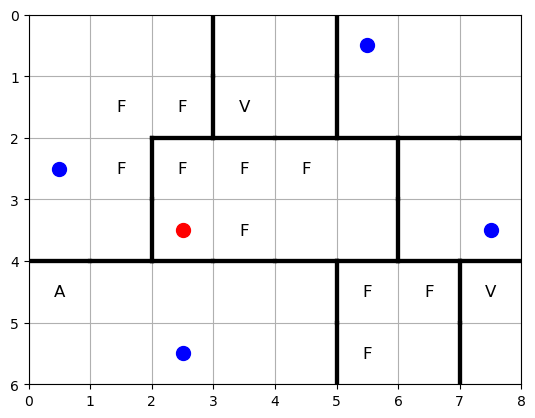

In [120]:
FIREFIGHTERS = 1
WALLDATA = wallData
DOORS = doors
ENTRYPOINTS = entryPoints
FIREPOI = FirePOI
ITERATIONS = 50

model = FireModel(WALLDATA, DOORS, ENTRYPOINTS, FIREPOI, FIREFIGHTERS)

for i in range(ITERATIONS):
    model.step()

model.visualize_grid()


all_grid = model.datacollector.get_model_vars_dataframe()

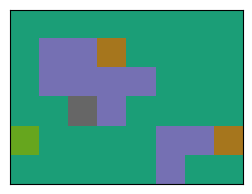

In [121]:
fig, axs = plt.subplots(figsize=(3, 3))
axs.set_xticks([])
axs.set_yticks([])

# Obtener la primera cuadrícula para inicializar la visualización
first_grid = all_grid.iloc[0]["Grid"]

patch = plt.imshow(first_grid, cmap=plt.cm.Dark2)

def animate(i):
   patch.set_data(all_grid.iloc[i]['Grid'])

anim = animation.FuncAnimation(fig, animate, frames=len(all_grid))

In [122]:
anim